# Amazon Copurchased

This is a Python notebook created using "jupyter".

Author: Rafael J. P. dos Santos

## Parameters

We use the parameter below to set the maximum number of edges to be read from the CSV containing edges (links).

In [28]:
max_edges = 10000 # Set quantity to read from file
edges_csv_file = "data/20180812_links"
nodes_csv_file = "data/20180812_nodes"

## Load the libraries

Let's load the Python libraries that we will need throughout the script

In [29]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.tree import export_graphviz
import pydot
from sklearn.ensemble import RandomForestRegressor
from __future__ import division
import sklearn
#from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
import hashlib
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.20.2.


## Read graph

### Read only first lines of datafile

Due to slowness in calculating centrality measures, we use the parameter provided in the beggining of the script to limit the number of edges we will read.

In [30]:
lines = []
total_line_count = 0
with open(edges_csv_file, 'rb') as f:
    f.readline()   # skip first line / header
    while True:
        line = f.readline()
        if not line:
            break
        if not (max_edges > 0 and len(lines) >= max_edges):
            lines.append(line)
        total_line_count += 1
G = nx.parse_edgelist(lines, delimiter=',', nodetype=int)

In [31]:
print "Using %d edges out of %d available (%.2f%% of data)" % (len(lines), total_line_count, len(lines)/total_line_count * 100)

Using 10000 edges out of 229338 available (4.36% of data)


### Calculate nodes centrality measures

Now that we have our NetworkX graph, let's calculate some centrality measures for every node.

In [32]:
centrality_measures = {}

#### Degree

In [33]:
centrality_measures["degree"] = nx.degree(G)

#### Eigenvector centrality

In [34]:
centrality_measures["eigenvector_centrality"] = nx.eigenvector_centrality_numpy(G)

####  Approximate betweenness centrality (current flow)

In [35]:
centrality_measures["betweenness_centrality"] = nx.approximate_current_flow_betweenness_centrality(G)

#### Closeness centrality

In [8]:
# Very slow!
centrality_measures["closeness_centrality"] = nx.closeness_centrality(G)

#### Betweenness centrality

In [9]:
# Very slow!
centrality_measures["betweenness_centrality"] = nx.betweenness_centrality(G)

### Load node properties

Let's load the CSV containing the nodes data (title, price) into a Pandas dataframe, and append the centrality measures calculated above.

In [36]:
df = pd.read_csv(nodes_csv_file)

####  Convert ID to random int to avoid leaking knowledge

In [37]:
sha256_ids = df['id'].map(lambda x: int(hashlib.sha256(str(x)).hexdigest()[0:15], 16))

In [38]:
# Add columns to dataframe
def merge_columns(dataframe, data):
    df = dataframe.copy()
    for col in data:
        rows = []
        for item in data[col].items():
            rows.append({"id": item[0], col: item[1]})
        df = df.merge(pd.DataFrame(rows))
    return df

df = merge_columns(df, centrality_measures)
df = merge_columns(df, {'sha256_id': sha256_ids})

### Let's convert some fields to numeric

In [39]:
categorical_features = [
    'category1',
    'category2',
    'category3',
    'category4',
    'category5',
    'category6',
    'category7',
    'category8',
    'category9',
    'category10',
    'language',
    'coverType',
    'publisher',
    'rankingCategory',
    'authors'
]

numeric_features = [
    #'degree',
    #'eigenvector_centrality',
    #'betweenness_centrality',
    'ranking',
    'reviewCount',
    'pages',
    'weight',
    'height',
    'width',
    'depth',
    'rating'
]

df = df.replace("<<MISSING_DATA>>", np.NaN)
df[numeric_features] = df[numeric_features].apply(pd.to_numeric)
df[['price']] = df[['price']].apply(pd.to_numeric)

for feature in numeric_features:
    df[feature].fillna(df[feature].mean(), inplace = True)

### Remove nodes without price and outliers

In [40]:
df = df.drop(df[df["price"].isnull()].index)
#df = df.drop(df[df["price"] > 500].index)

### Inspect columns

In [41]:
df.columns

Index([u'id', u'title', u'url', u'authors', u'coverType', u'publisher',
       u'edition', u'publicationDate', u'rankingCategory', u'category1',
       u'category2', u'category3', u'category4', u'category5', u'category6',
       u'category7', u'category8', u'category9', u'category10', u'isbn10',
       u'isbn13', u'language', u'postProcessed', u'price', u'ranking',
       u'pages', u'reviewCount', u'rating', u'width', u'height', u'depth',
       u'weight', u'eigenvector_centrality', u'degree',
       u'betweenness_centrality', u'sha256_id'],
      dtype='object')

### Features summary

Below we have a summary of the Pandas dataframe. We can see the number of nodes that we are actually analyzing, which depends on the max_edges parameter defined before.

In [42]:
df.describe(include='all')

,id,title,url,authors,coverType,publisher,edition,publicationDate,rankingCategory,category1,category2,category3,category4,category5,category6,category7,category8,category9,category10,isbn10,isbn13,language,postProcessed,price,ranking,pages,reviewCount,rating,width,height,depth,weight,eigenvector_centrality,degree,betweenness_centrality,sha256_id
count,1887.000000,1887,1887,1887,1872,1874,0.0,273,1662,1637,1637,1365,814,461,117,9,0.0,0.0,0.0,1876,1876,1876,1887.0,1887.000000,1887.000000,1887.000000,1887.000000,1887.000000,1887.000000,1887.000000,1887.000000,1887.000000,1.887000e+03,1887.000000,1887.000000,1.887000e+03
unique,NaN,1840,1887,1466,7,288,NaN,243,1,1,23,112,185,120,42,5,NaN,NaN,NaN,1876,1876,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Macroeconomia,https://www.amazon.com.br/dp/0198769865/,Ian Stewart (Autor),Capa comum,Companhia das Letras,NaN,17 de outubro de 2017,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Matemática,Faculdade,Probabilidade e Estatística,Abstrata,NaN,NaN,NaN,8521631030,978-8590200215,Português,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,5,1,12,1508,98,NaN,3,1662,1637,399,283,136,41,14,3,NaN,NaN,NaN,1,1,1263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1643.043985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,148.906746,58197.556473,412.825546,13.727257,4.481211,15.993920,22.953013,2.305302,467.427140,8.119221e-03,9.182830,0.003923,5.659640e+17
std,1817.245542,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,266.318411,74967.622490,269.695568,34.297497,0.496588,2.877004,2.804110,1.213144,209.671432,2.103019e-02,18.597254,0.012210,3.296763e+17
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,5.900000,7.000000,4.000000,1.000000,1.000000,2.600000,14.000000,0.200000,18.100000,8.902568e-08,1.000000,0.000000,2.661967e+14
25%,509.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,35.900000,11609.000000,232.000000,3.000000,4.484431,14.000000,21.000000,1.400000,340.000000,7.787527e-06,1.000000,0.000000,2.782992e+17
50%,1218.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,56.900000,36009.000000,352.000000,13.782918,4.484431,15.600000,22.900000,2.000000,470.363783,6.130131e-05,2.000000,0.000357,5.616563e+17
75%,1907.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,129.090000,60184.500000,528.000000,13.782918,4.700000,17.200000,24.100000,2.900000,581.000000,2.193281e-03,8.000000,0.003016,8.439017e+17


Below we can inspect the first rows of data, containing title, price, degree and other centrality measures.

In [43]:
df.head(10)

,id,title,url,authors,coverType,publisher,edition,publicationDate,rankingCategory,category1,category2,category3,category4,category5,category6,category7,category8,category9,category10,isbn10,isbn13,language,postProcessed,price,ranking,pages,reviewCount,rating,width,height,depth,weight,eigenvector_centrality,degree,betweenness_centrality,sha256_id
0,1,The Stanford Mathematics Problem Book: With Hi...,https://www.amazon.com.br/dp/0486469247/,"George Polya (Autor),",Capa comum,Dover Publications,NaN,19 de fevereiro de 2009,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Matemática,Estudo e Ensino,NaN,NaN,NaN,NaN,NaN,0486469247,978-0486469249,Inglês,1,26.25,59183.0,68.0,1.000000,4.000000,14.0,21.0,0.6,181.0,0.014272,19,0.009125,956792697637953902
1,2,Fourier Series,https://www.amazon.com.br/dp/0486633179/,"Georgi P. Tolstov (Autor),",Capa comum,Dover Publications,NaN,1 de junho de 1976,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Matemática,Aplicada,Probabilidade e Estatística,NaN,NaN,NaN,NaN,0486633179,978-0486633176,Inglês,1,50.37,56112.0,352.0,3.000000,4.600000,14.6,21.0,1.9,363.0,0.060501,62,0.006017,351408350089178552
2,3,Probability Theory: A Concise Course,https://www.amazon.com.br/dp/0486635449/,"Y. A. Rozanov (Autor),",Capa comum,Dover Publications,NaN,NaN,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Matemática,Aplicada,Probabilidade e Estatística,NaN,NaN,NaN,NaN,0486635449,978-0486635446,Inglês,1,29.23,44345.0,160.0,13.782918,4.484431,14.4,20.8,0.8,200.0,0.041809,59,0.012384,338376316163052028
3,4,"Vectors, Tensors and the Basic Equations of Fl...",https://www.amazon.com.br/dp/0486661105/,"Rutherford Aris (Autor),",Capa comum,Dover Publications,NaN,NaN,Livros,Livros,Inglês e Outras Línguas,Engenharia e Transporte,Engenharia,Mecânica,Hidráulica,NaN,NaN,NaN,NaN,0486661105,978-0486661100,Inglês,1,48.79,82275.0,320.0,2.000000,4.500000,13.7,21.5,1.6,381.0,0.013503,18,0.005479,1077153230057093442
4,5,Ordinary Differential Equations,https://www.amazon.com.br/dp/0486649407/,"Morris Tenenbaum (Autor),",Capa comum,Dover Publications,NaN,NaN,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Matemática,Aplicada,Equações Diferenciais,NaN,NaN,NaN,NaN,0486649407,978-0486649405,Inglês,1,71.63,40840.0,848.0,4.000000,4.500000,13.8,21.8,4.0,939.0,0.084038,88,0.020152,1044672390517680347
5,6,The Variational Principles of Mechanics,https://www.amazon.com.br/dp/0486650677/,"Cornelius Lanczos (Autor),",Capa comum,Dover Publications,NaN,NaN,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Física,Mecânica,NaN,NaN,NaN,NaN,NaN,0486650677,978-0486650678,Inglês,1,88.15,36960.0,418.0,1.000000,5.000000,13.8,21.5,2.2,581.0,0.051176,43,0.012409,544977996675729576
6,7,A First Look at Perturbation Theory,https://www.amazon.com.br/dp/0486675513/,James G. Simmonds (Autor),Capa comum,Dover Publications Inc.,NaN,NaN,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Matemática,Aplicada,Equações Diferenciais,NaN,NaN,NaN,NaN,0486675513,978-0486675510,Inglês,1,36.10,37291.0,160.0,13.782918,4.484431,13.7,21.5,0.8,159.0,0.010229,9,0.003103,199886966959710743
7,8,Thermodynamics and the Kinetic Theory of Gases...,https://www.amazon.com.br/dp/0486414612/,"Wolfgang Pauli (Autor),",Capa comum,Dover Publications,NaN,18 de outubro de 2010,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Física,Dinâmica,Termodinâmica,NaN,NaN,NaN,NaN,0486414612,978-0486414614,Inglês,1,26.01,24406.0,160.0,2.000000,5.000000,13.8,21.6,1.0,159.0,0.005257,10,0.012265,114140175342751440
8,9,Mechanics,https://www.amazon.com.br/dp/0486607542/,"Jacob P. Den Hartog (Autor),",Capa comum,Dover Publications,NaN,1 de junho de 1961,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Física,Mecânica,NaN,NaN,NaN,NaN,NaN,0486607542,978-0486607542,Inglês,1,50.96,90609.0,480.0,13.782918,4.484431,13.6,20.3,2.3,522.0,0.022270,23,0.001894,334477765055357002
9,10,Statistical Thermodynamics,https://www.amazon.com.br/dp/048666

## Random forest using degree as feature, price as target

### Preparing data

In [44]:
df_with_dummies = pd.get_dummies(df[['sha256_id'] + numeric_features + categorical_features + ['price']],columns=categorical_features,drop_first=True)

In [45]:
feature_list = list(df_with_dummies.drop(columns = ['price']))
features = np.array(df_with_dummies.drop(columns = ['price']))
target = np.array(df_with_dummies['price'])

### Average price as baseline

It's important to have a baseline, so we can validate our predictions after running our model. One easy choice for baseline is the average price of a book.

We have an average price around R\$43, so this means that a very easy prediction would be to always guess R$43 for the price of any book.

In [46]:
average_target = np.average(target)
print "Average price: R$", average_target

Average price: R$ 148.9067461579226


### Cross val score

In [47]:
def baseline_score_function (y_true, y_pred):
    errors_baseline = abs(average_target - y_true)
    return np.mean(errors_baseline)

rf = RandomForestRegressor(n_estimators = 50, n_jobs = -1)

scorer = make_scorer(baseline_score_function)

scores = cross_validate(estimator=rf, X=features, y=target, cv=10,
                        scoring = {'abs': 'neg_mean_absolute_error', 'baseline': scorer},
                        return_train_score=False, return_estimator = True)

#print "Abs: ", scores['test_abs']
print "RF abs mean: ", np.mean(np.abs(scores['test_abs']))
print "RF abs std: ", np.std(scores['test_abs'])

#print "Baseline: ", scores['test_baseline']
print "Baseline mean: ", np.mean(scores['test_baseline'])
print "Baseline std: ", np.std(scores['test_baseline'])

# Use best estimator to do some visual reports
rf = scores['estimator'][0]

RF abs mean:  62.00671380164359
RF abs std:  62.835071673316754
Baseline mean:  146.61196857609144
Baseline std:  87.01062347962278


In [48]:
predictions = rf.predict(features)
test_target = target
test_features = features

####  List of most important features

In [49]:
importance = zip(feature_list, rf.feature_importances_)
importance.sort(key=lambda x:-x[1])
pd.DataFrame(importance).head(200)

,0,1
0,coverType_Capa dura,0.201336
1,pages,0.153227
2,ranking,0.097941
3,width,0.069739
4,language_Inglês,0.068103
5,publisher_Cengage Learning,0.046749
6,category2_Inglês e Outras Línguas,0.040459
7,publisher_McGraw-Hill Science/Engineering/Math,0.036459
8,height,0.034390
9,language_Português,0.028484


####  Preço previsto vs. Preço real

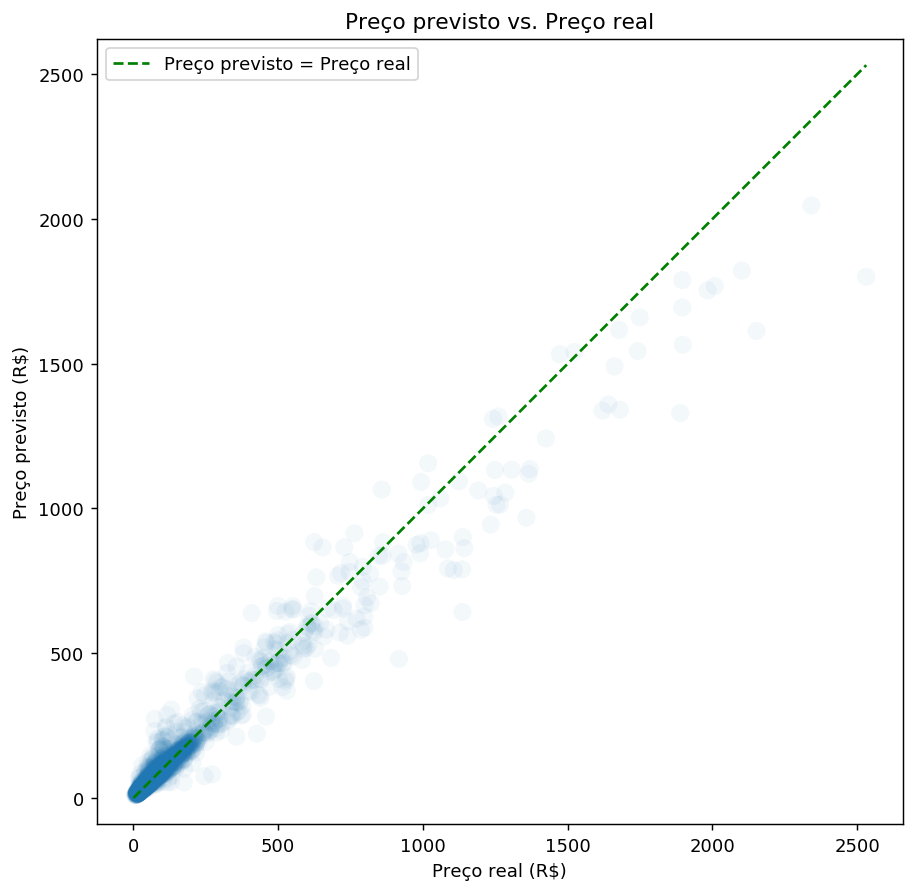

In [50]:
plt.figure(figsize=(8,8), dpi=130)
plt.scatter(target, predictions, 100, alpha=0.05, edgecolors="none")
baseline = [0, np.max(target)]
plt.plot(baseline, baseline, "--", color="green", label = u"Preço previsto = Preço real")
ax = plt.gca()
ax.set_ylabel(u"Preço previsto (R$)")
ax.set_xlabel(u"Preço real (R$)")
ax.legend()
plt.title(u"Preço previsto vs. Preço real")
plt.axes().set_aspect('equal', 'datalim')
#plt.xlim(0, 150)
#plt.ylim(0, 150)
plt.show()

### Mean absolute error

Now we can compare the errors obtained by our predictions against the errors provided by the baseline (average price). Our prediction errors should be less than the baseline errors to consider the model successful.

In [51]:
# Calculate the absolute errors
errors = abs(predictions - test_target)
errors_baseline = abs(average_target - test_target)
# Print out the mean absolute error (mae)
print('Mean absolute prediction error: R$', round(np.mean(errors), 2))
print('Mean absolute error using average: R$',
      round(np.mean(errors_baseline), 2))

('Mean absolute prediction error: R$', 22.43)
('Mean absolute error using average: R$', 146.49)


### Worst predictions

Below we can inspect the rows with the biggest prediction error.

In [52]:
pd.set_option('display.max_columns', None)
data = {
    "all_features": test_features.tolist(),
    "sha256_id": test_features[:, 0],
    "target": test_target,
    "prediction": predictions,
    "error": errors,
    "errors_baseline": errors_baseline
}
predicted_df = pd.DataFrame(data = data)
joined_predicted_df = predicted_df
joined_predicted_df = predicted_df.set_index("sha256_id").join(df.set_index("sha256_id"))
joined_predicted_df.sort_values('error', ascending = False).head(20)

,all_features,error,errors_baseline,prediction,target,id,title,url,authors,coverType,publisher,edition,publicationDate,rankingCategory,category1,category2,category3,category4,category5,category6,category7,category8,category9,category10,isbn10,isbn13,language,postProcessed,price,ranking,pages,reviewCount,rating,width,height,depth,weight,eigenvector_centrality,degree,betweenness_centrality
sha256_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1.225534e+17,"[1.22553373673e+17, 59185.8447277, 13.78291814...",731.0680,2382.163254,1800.0020,2531.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.458596e+16,"[2.45859614126e+16, 311760.0, 13.7829181495, 5...",559.3158,1739.853254,1329.4442,1888.76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.132778e+17,"[2.13277821184e+17, 59185.8447277, 13.78291814...",539.1512,2003.263254,1613.0188,2152.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.922505e+17,"[2.9225054914e+17, 59185.8447277, 13.782918149...",494.0524,987.373254,642.2276,1136.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6.027474e+17,"[6.02747351128e+17, 59185.8447277, 13.78291814...",436.7292,768.043254,480.2208,916.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5.352010e+17,"[5.35201034415e+17, 59185.8447277, 13.78291814...",389.4496,1208.093254,967.5504,1357.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.466272e+17,"[2.46627170426e+17, 433962.0, 13.7829181495, 2...",345.7960,986.393254,789.5040,1135.30,1789.0,An Introduction to Quantum Computing,https://www.amazon.com.br/dp/0198570007/,"Phillip Kaye (Autor),",Capa dura,OUP Oxford,NaN,NaN,Livros,Livros,Inglês e Outras Línguas,"Computação, Informática e Mídias Digitais",Hardware,Mainframes e Minicomputadores,NaN,NaN,NaN,NaN,NaN,0198570007,978-0198570004,Inglês,1.0,1135.30,433962.000000,288.0,13.782918,4.484431,15.7,23.1,2.0,544.000000,0.031950,13.0,0.001651
4.991784e+17,"[4.99178403545e+17, 59185.8447277, 13.78291814...",339.0530,1531.183254,1341.0370,1680.09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6.275439e+16,"[6.27543918461e+16, 59185.8447277, 13.78291814...",332.0510,1748.663254,1565.5190,1897.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Best predictions

In [53]:
joined_predicted_df.sort_values('error', ascending = True).head(20)

,all_features,error,errors_baseline,prediction,target,id,title,url,authors,coverType,publisher,edition,publicationDate,rankingCategory,category1,category2,category3,category4,category5,category6,category7,category8,category9,category10,isbn10,isbn13,language,postProcessed,price,ranking,pages,reviewCount,rating,width,height,depth,weight,eigenvector_centrality,degree,betweenness_centrality
sha256_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8.276645e+17,"[8.27664459767e+17, 2240.0, 7.0, 296.0, 399.0,...",0.0038,120.506746,28.3962,28.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9.888800e+17,"[9.88879979666e+17, 754.0, 19.0, 408.0, 358.0,...",0.0040,89.006746,59.9040,59.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6.250880e+17,"[6.25088000644e+17, 16126.0, 1.0, 192.0, 322.0...",0.0046,115.006746,33.8954,33.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6.466861e+17,"[6.46686084918e+17, 14215.0, 5.0, 733.0, 470.3...",0.0048,9.143254,158.0548,158.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6.284479e+17,"[6.28447876617e+17, 59185.8447277, 13.78291814...",0.0098,101.316746,47.5802,47.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4.961929e+17,"[4.96192914416e+17, 4411.0, 150.0, 336.0, 440....",0.0168,109.006746,39.9168,39.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.617362e+17,"[2.61736201939e+17, 60598.0, 5.0, 304.0, 358.0...",0.0196,105.006746,43.8804,43.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5.754774e+17,"[5.75477400052e+17, 20564.0, 6.0, 976.0, 470.3...",0.0200,40.893254,189.8200,189.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8.632084e+17,"[8.63208355155e+17, 12805.0, 47.0, 264.0, 513....",0.0236,116.266746,32.6164,32.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
predicted_df.describe()

,error,errors_baseline,prediction,sha256_id,target
count,1887.000000,1887.000000,1887.000000,1.887000e+03,1887.000000
mean,22.428908,146.494616,145.486116,5.659640e+17,148.906746
std,51.507694,222.381305,236.700897,3.296763e+17,266.318411
min,0.003800,0.006746,9.211000,2.661967e+14,5.900000
25%,1.973600,73.686746,37.171700,2.782992e+17,35.900000
50%,5.422000,104.296746,58.356200,5.616563e+17,56.900000
75%,18.089200,123.276746,138.531500,8.439017e+17,129.090000
max,731.068000,2382.163254,2046.761800,1.152172e+18,2531.070000


### Visualize decision tree

In [27]:
# Pull out one tree from the forest
tree = rf.estimators_[0]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot',
                feature_names = feature_list, rounded = True)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')

<img src="files/image.png">